Created by <br> Nimisha Asati <br>


In [ ]:
import torch
import torchvision 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

import pickle
import time
import os
import copy

plt.ion()
## Importing required kibraries

import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt   
from IPython.display import clear_output
import pickle
from sklearn.metrics.pairwise import cosine_similarity

import torch
from torch.autograd import Variable
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torch import optim

## Question 1

ResNet-18 expects images to be at least 224x224, as well as normalized with a specific mean and standard deviation. So we will first define some PyTorch transforms.
Here, we are flipping the image horiozntally using __RandomHorizontalFlip__ with probability of image being flipped = 50%.
The last transform __‘to_tensor’__ is used to convert the PIL image to a PyTorch tensor (multidimensional array).

<div class="alert alert-block alert-success">
<b>We used two Transformations: Flip and Rotation</b> 

Model with image random Rotation: **66.5%** <br>
Model with image random Flip: **75.5%**
</div>

In [17]:
def imshow(img,title=None):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.show()     

## Function for Training the Model

We also set the model to evaluation mode in order to ensure that any Dropout layers are not active during the forward pass.
To evaluate the image with the model, we send the input data to the __model.eval__ method.
We scheduled the __learning rate__ using LR scheduler object.

In [3]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=15):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                #data into the processing unit
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Question 1) 1.a Fixed Feature Extraction
PyTorch downloads the pretrained weights when running for the first time. <br> We used the pretrained Resnet18 model (from torchvision) to extract features and use them as inputs in a new multi-class logistic regression model.
<br> Here, we have only optimized parameters of our final layer.
<br> Since, we don't want to change the input, we have set __param.requires_grad as 'False'__.

### Transformation 1: Model with random Flip

In [5]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
         transforms.Resize(224),
         transforms.RandomCrop(224,pad_if_needed=True),
         transforms.RandomHorizontalFlip(p=0.5),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
    'val': transforms.Compose([
        # transforms.RandomCrop(224,pad_if_needed=True),
         transforms.Resize(224),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
}

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=data_transforms.get("train"))
testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=data_transforms.get("val"))
dataloaders ={"train":torch.utils.data.DataLoader(trainset, batch_size=4,shuffle=True, num_workers=2)}
dataloaders["val"] = torch.utils.data.DataLoader(testset, batch_size=4,shuffle=False, num_workers=2)

classes = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']
#dataset_sizes = {"train":len(trainset.train_data)*4,"val":len(testset.test_data)*4}
dataset_sizes = {"train":len(trainset.train_data),"val":len(testset.test_data)}
validation_labels = np.array(testset.test_labels)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Files already downloaded and verified
Files already downloaded and verified
cuda:0


In [6]:
model_conv = models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 10)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [12]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                        exp_lr_scheduler, num_epochs=15)

Epoch 0/14
----------
train Loss: 1.1865 Acc: 0.6105
val Loss: 0.8236 Acc: 0.7414

Epoch 1/14
----------
train Loss: 1.1158 Acc: 0.6411
val Loss: 0.6872 Acc: 0.7775

Epoch 2/14
----------
train Loss: 1.1122 Acc: 0.6465
val Loss: 0.7074 Acc: 0.7748

Epoch 3/14
----------
train Loss: 1.1133 Acc: 0.6499
val Loss: 0.6920 Acc: 0.7776

Epoch 4/14
----------
train Loss: 1.0927 Acc: 0.6523
val Loss: 0.7263 Acc: 0.7766

Epoch 5/14
----------
train Loss: 1.1065 Acc: 0.6482
val Loss: 0.7278 Acc: 0.7677

Epoch 6/14
----------
train Loss: 1.1027 Acc: 0.6506
val Loss: 0.7175 Acc: 0.7688

Epoch 7/14
----------
train Loss: 0.9466 Acc: 0.6911
val Loss: 0.6758 Acc: 0.7787

Epoch 8/14
----------
train Loss: 0.9318 Acc: 0.6945
val Loss: 0.6460 Acc: 0.7863

Epoch 9/14
----------
train Loss: 0.9224 Acc: 0.6936
val Loss: 0.6837 Acc: 0.7721

Epoch 10/14
----------
train Loss: 0.9208 Acc: 0.6943
val Loss: 0.6478 Acc: 0.7843

Epoch 11/14
----------
train Loss: 0.9258 Acc: 0.6941
val Loss: 0.6533 Acc: 0.7796

Ep

<div class="alert alert-block alert-warning">
<b>Question 1) 2.b  Displaying top 5 correct predictions and incorrect predictions in each class for __FLIP MODEL__</b> 
    <br>
    Labels are shown for the predictions. Correct prediction has one label whereas incorrect prediction has all 5 labels showing that it is incorrectly predicted.</br>

In [ ]:
def top_correct_incorrect(model_conv,actual,classes,data_iter):
    output_scores = torch.zeros((1,10)).cuda()
    model_conv.eval()
    with torch.no_grad():
        for i,(inputs,labels) in enumerate(data_iter):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model_conv(inputs)
            _,preds = torch.max(outputs,1)
            output_scores = torch.cat((outputs,output_scores),dim=0)
        output_scores = output_scores.cpu().numpy()[:dataset_sizes["val"]]

    for cifar in range(0,len(classes)):
        img1 = []
        img2= []
        prediction_labels = []
        indices = np.where(actual==cifar)[0]
        tmp = output_scores[indices,cifar]
        top_scores_indices = np.argsort(tmp)[::-1]
        top_correct_indices = top_scores_indices[:5]
        top_correct_preds = indices[top_correct_indices]
        for val in top_correct_preds:
            img1.append(data_iter.dataset[val][0])

        top_incorrect_indices = top_scores_indices[-5:]
        top_incorrect_preds = indices[top_incorrect_indices]
        wrong_predictions = output_scores[top_incorrect_preds]
        for val in top_incorrect_preds:
            pred = classes[np.argmax(output_scores[val])]
            if pred!=cifar:
                prediction_labels.append(pred)
                img2.append(data_iter.dataset[val][0])

        print("Class:",classes[cifar])
        print("Top Correct Prediction")
        imshow(torchvision.utils.make_grid(img1))
        if len(img1)>0:
            print("Top Incorrect Prediction")   
            imshow(torchvision.utils.make_grid(img2),title= prediction_labels)
            print("==========================================================================")
        else:
            print("No Incorrect Predictions")

Class: plane
Top Correct Prediction


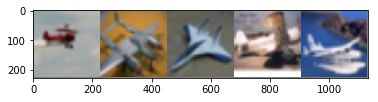

Top Incorrect Prediction


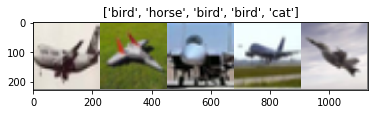

Class: car
Top Correct Prediction


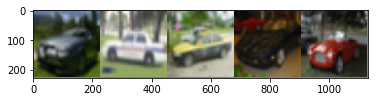

Top Incorrect Prediction


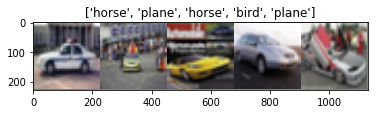

Class: bird
Top Correct Prediction


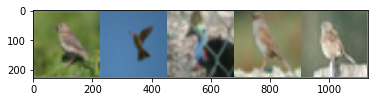

Top Incorrect Prediction


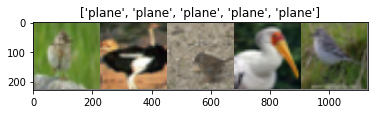

Class: cat
Top Correct Prediction


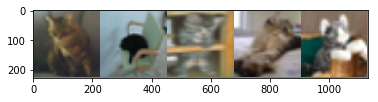

Top Incorrect Prediction


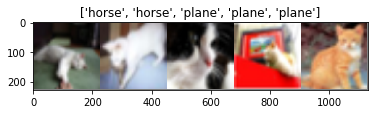

Class: deer
Top Correct Prediction


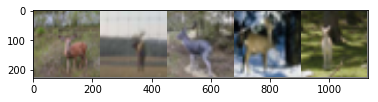

Top Incorrect Prediction


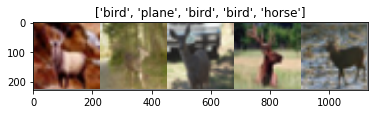

Class: dog
Top Correct Prediction


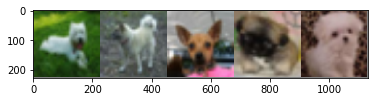

Top Incorrect Prediction


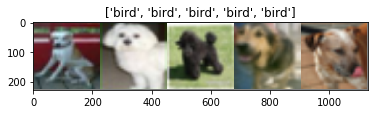

Class: frog
Top Correct Prediction


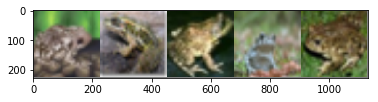

Top Incorrect Prediction


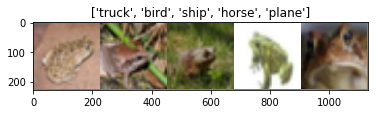

Class: horse
Top Correct Prediction


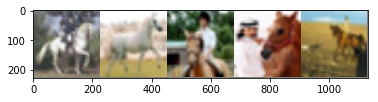

Top Incorrect Prediction


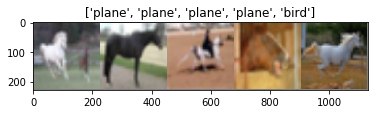

Class: ship
Top Correct Prediction


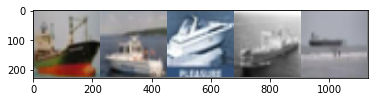

Top Incorrect Prediction


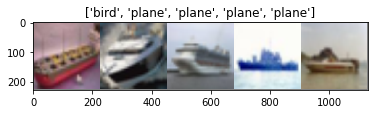

Class: truck
Top Correct Prediction


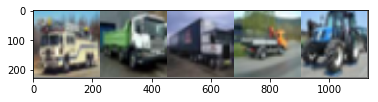

Top Incorrect Prediction


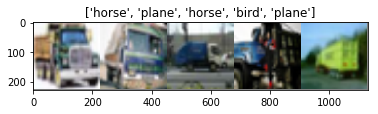

In [18]:
top_correct_incorrect(model_conv,validation_labels,classes,dataloaders["val"])

### Fine Tuning the features for flip model

In fine tuning, the weights of the pre-trained CNN model are preserved on some of layers and tuned in the others.
<br> We adjusted the learning parameters below and observed the results. We can tweak the __num_epochs__ to train for longer, __batch_size__ to adjust the size of each minibatch, __gamma__ to play with the speed of convergence (learning rate), or __step_size__ to move towards the minima.

In [42]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 10)

We are __<font color=blue>Freezing</font>__ few layers increase the computational speed.
Here, we are freezing first 5 layers.
When we tried to freeze first 10 layers, the testing accuracy decreased to 80%,
which was almost similar to that without fine-tuning.
We have set ``requires_grad == False`` to freeze the parameters so that the gradients are not computed in ``backward()`

We also tried to increase the __<font color=blue>batch_size</font>__ from 4 to 20, but it lead to overfit.

In [43]:
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

ct = 0
for child in model_ft.children():
    ct += 1
    if ct < 6:
        for param in child.parameters():
            param.requires_grad = False
            
model_ft.fc = nn.Linear(512, 10)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
model_ft = model_ft.to(device)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15)

Epoch 0/14
----------
train Loss: 0.7045 Acc: 0.7758
val Loss: 0.2904 Acc: 0.9068

Epoch 1/14
----------
train Loss: 0.4096 Acc: 0.8714
val Loss: 0.2507 Acc: 0.9145

Epoch 2/14
----------
train Loss: 0.3007 Acc: 0.9040
val Loss: 0.2430 Acc: 0.9243

Epoch 3/14
----------
train Loss: 0.2440 Acc: 0.9226
val Loss: 0.2354 Acc: 0.9239

Epoch 4/14
----------
train Loss: 0.2024 Acc: 0.9359
val Loss: 0.2936 Acc: 0.9083

Epoch 5/14
----------
train Loss: 0.1659 Acc: 0.9465
val Loss: 0.2150 Acc: 0.9284

Epoch 6/14
----------
train Loss: 0.1399 Acc: 0.9564
val Loss: 0.2529 Acc: 0.9156

Epoch 7/14
----------
train Loss: 0.0715 Acc: 0.9797
val Loss: 0.1607 Acc: 0.9474

Epoch 8/14
----------
train Loss: 0.0537 Acc: 0.9851
val Loss: 0.1480 Acc: 0.9506

Epoch 9/14
----------
train Loss: 0.0423 Acc: 0.9881
val Loss: 0.1482 Acc: 0.9493

Epoch 10/14
----------
train Loss: 0.0423 Acc: 0.9885
val Loss: 0.1496 Acc: 0.9504

Epoch 11/14
----------
train Loss: 0.0352 Acc: 0.9907
val Loss: 0.1441 Acc: 0.9542

Ep

### Performance with Fine tuning
Our performance improved greatly with the highest __testing accuracy__ being __99.5%__.

#### 2b) Showing top 5 correct and incorrect predictions in each class with Fine Tuning for FLIP MODEL:
 <div class="alert alert-block alert-warning">
<b>Question 1) 2.b  Displaying top 5 correct predictions and incorrect predictions in each class for __FLIP MODEL__</b> 
    <br>
    Labels are shown for the predictions. Correct prediction has one label whereas incorrect prediction has all 5 labels showing that it is incorrectly predicted.</br>

In [11]:
def imshow(img,title=None):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.show()

Class: plane
Top Correct Prediction


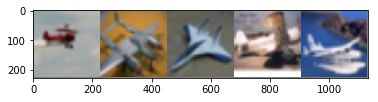

Top Incorrect Prediction


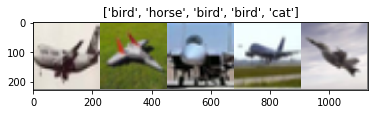

Class: car
Top Correct Prediction


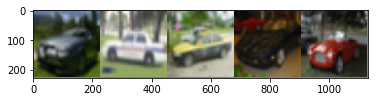

Top Incorrect Prediction


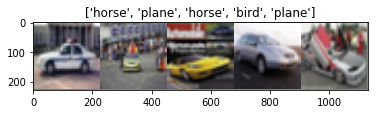

Class: bird
Top Correct Prediction


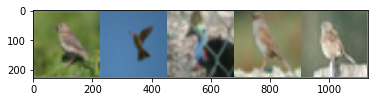

Top Incorrect Prediction


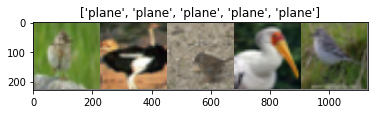

Class: cat
Top Correct Prediction


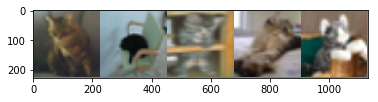

Top Incorrect Prediction


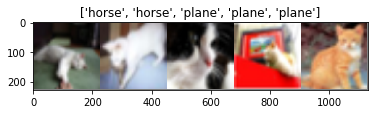

Class: deer
Top Correct Prediction


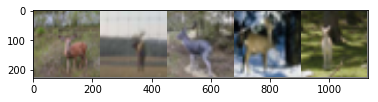

Top Incorrect Prediction


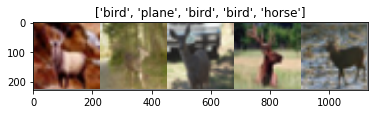

Class: dog
Top Correct Prediction


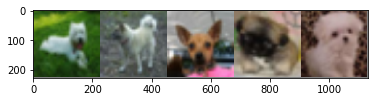

Top Incorrect Prediction


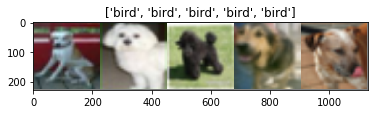

Class: frog
Top Correct Prediction


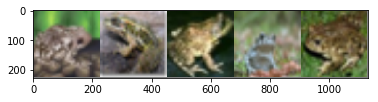

Top Incorrect Prediction


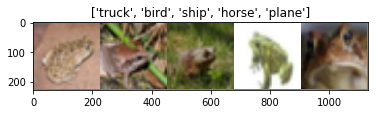

Class: horse
Top Correct Prediction


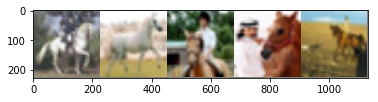

Top Incorrect Prediction


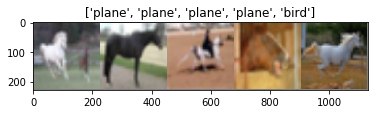

Class: ship
Top Correct Prediction


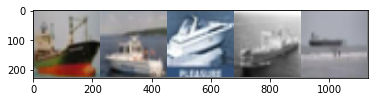

Top Incorrect Prediction


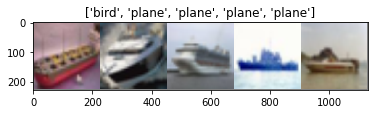

Class: truck
Top Correct Prediction


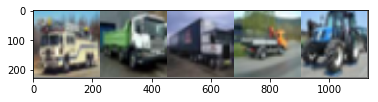

Top Incorrect Prediction


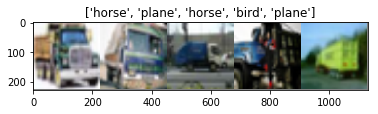

In [15]:
top_correct_incorrect(model_conv,validation_labels,classes,dataloaders["val"])

***

### Transformation 2: Image Random Rotation
Here, we are flipping the image horiozntally using __RandomRotation__ with 90 degrees.
The last transform __‘to_tensor’__ is used to convert the PIL image to a PyTorch tensor (multidimensional array).

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
         transforms.Resize(224),
         transforms.RandomCrop(224,pad_if_needed=True),
         transforms.RandomRotation(90, resample=False, expand=False, center=None),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
    'val': transforms.Compose([
        # transforms.RandomCrop(224,pad_if_needed=True),
         transforms.Resize(224),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
}

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=data_transforms.get("train"))
testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=data_transforms.get("val"))
dataloaders ={"train":torch.utils.data.DataLoader(trainset, batch_size=4,shuffle=True, num_workers=2)}
dataloaders["val"] = torch.utils.data.DataLoader(testset, batch_size=4,shuffle=False, num_workers=2)

classes = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']
#dataset_sizes = {"train":len(trainset.train_data)*4,"val":len(testset.test_data)*4}
dataset_sizes = {"train":len(trainset.train_data),"val":len(testset.test_data)}
validation_labels = np.array(testset.test_labels)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                        exp_lr_scheduler, num_epochs=15)

Epoch 0/14
----------
train Loss: 1.6871 Acc: 0.4390
val Loss: 1.8106 Acc: 0.4847

Epoch 1/14
----------
train Loss: 1.6195 Acc: 0.4714
val Loss: 1.3509 Acc: 0.5764

Epoch 2/14
----------
train Loss: 1.6169 Acc: 0.4728
val Loss: 1.7376 Acc: 0.4903

Epoch 3/14
----------
train Loss: 1.5981 Acc: 0.4812
val Loss: 1.1865 Acc: 0.6316

Epoch 4/14
----------
train Loss: 1.6037 Acc: 0.4760
val Loss: 1.0374 Acc: 0.6650

Epoch 5/14
----------
train Loss: 1.6018 Acc: 0.4796
val Loss: 1.3651 Acc: 0.5878

Epoch 6/14
----------
train Loss: 1.6105 Acc: 0.4756
val Loss: 1.1412 Acc: 0.6320

Epoch 7/14
----------
train Loss: 1.3864 Acc: 0.5271
val Loss: 1.1472 Acc: 0.6301

Epoch 8/14
----------
train Loss: 1.3562 Acc: 0.5378
val Loss: 1.0191 Acc: 0.6551

Epoch 9/14
----------
train Loss: 1.3563 Acc: 0.5356
val Loss: 1.2148 Acc: 0.6003

Epoch 10/14
----------
train Loss: 1.3477 Acc: 0.5368
val Loss: 1.0311 Acc: 0.6534

Epoch 11/14
----------
train Loss: 1.3476 Acc: 0.5355
val Loss: 1.0751 Acc: 0.6371

Epoch 12/14
----------
train Loss: 1.3542 Acc: 0.5384
val Loss: 1.1858 Acc: 0.6083

Epoch 13/14
----------
train Loss: 1.3547 Acc: 0.5358
val Loss: 1.1715 Acc: 0.6105

Epoch 14/14
----------
train Loss: 1.3343 Acc: 0.5423
val Loss: 1.2049 Acc: 0.6028

Training complete in 42m 30s
Best val Acc: 0.665000

#### 2b) Showing top 5 correct and incorrect predictions in each class with Fine Tuning for ROTATION MODEL:
 <div class="alert alert-block alert-warning">
<b>Question 1) 2.b  Displaying top 5 correct predictions and incorrect predictions in each class for __ROTATION MODEL__</b> 
    <br>
    Labels are shown for the predictions. Correct prediction has one label whereas incorrect prediction has all 5 labels showing that it is incorrectly predicted.</br>

Class: plane
Top Correct Prediction


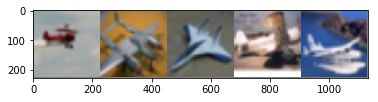

Top Incorrect Prediction


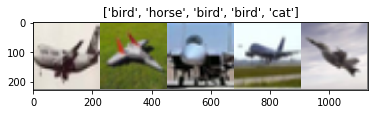

Class: car
Top Correct Prediction


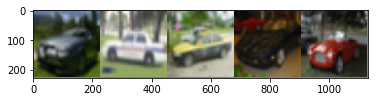

Top Incorrect Prediction


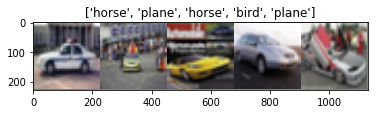

Class: bird
Top Correct Prediction


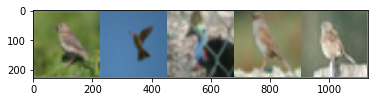

Top Incorrect Prediction


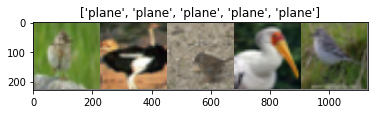

Class: cat
Top Correct Prediction


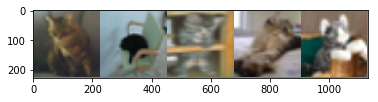

Top Incorrect Prediction


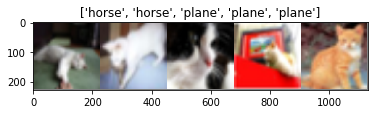

Class: deer
Top Correct Prediction


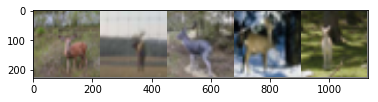

Top Incorrect Prediction


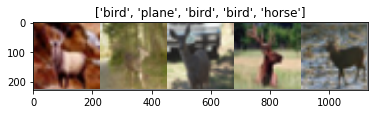

Class: dog
Top Correct Prediction


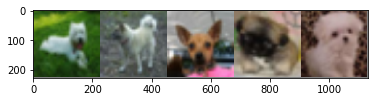

Top Incorrect Prediction


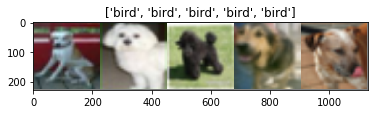

Class: frog
Top Correct Prediction


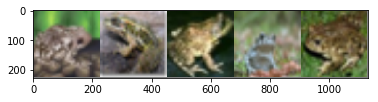

Top Incorrect Prediction


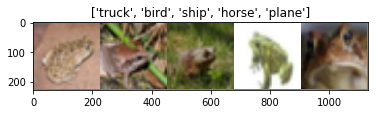

Class: horse
Top Correct Prediction


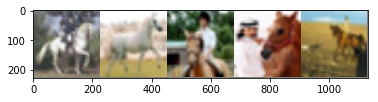

Top Incorrect Prediction


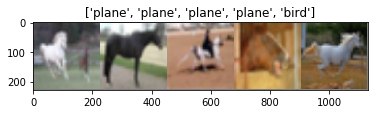

Class: ship
Top Correct Prediction


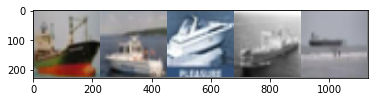

Top Incorrect Prediction


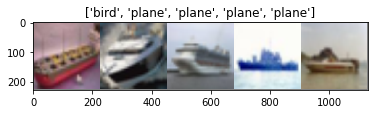

Class: truck
Top Correct Prediction


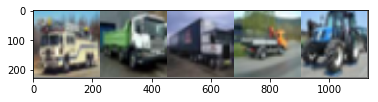

Top Incorrect Prediction


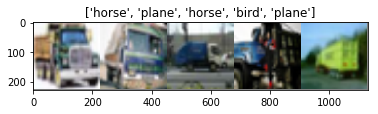

In [20]:
top_correct_incorrect(model_conv,validation_labels,classes,dataloaders["val"])

### Fine Tuning Rotation Model

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15)

Epoch 0/14
----------
train Loss: 1.1057 Acc: 0.6363
val Loss: 0.5122 Acc: 0.8292

Epoch 1/14
----------
train Loss: 0.7458 Acc: 0.7555
val Loss: 0.4548 Acc: 0.8507

Epoch 2/14
----------
train Loss: 0.6112 Acc: 0.7979
val Loss: 0.3964 Acc: 0.8667

Epoch 3/14
----------
train Loss: 0.5304 Acc: 0.8228
val Loss: 0.3565 Acc: 0.8810

Epoch 4/14
----------
train Loss: 0.4726 Acc: 0.8441
val Loss: 0.4586 Acc: 0.8534

Epoch 5/14
----------
train Loss: 0.4266 Acc: 0.8570
val Loss: 0.3554 Acc: 0.8845

Epoch 6/14
----------
train Loss: 0.3837 Acc: 0.8688
val Loss: 0.3015 Acc: 0.8980

Epoch 7/14
----------
train Loss: 0.2582 Acc: 0.9144
val Loss: 0.2558 Acc: 0.9132

Epoch 8/14
----------
train Loss: 0.2300 Acc: 0.9233
val Loss: 0.2298 Acc: 0.9241

Epoch 9/14
----------
train Loss: 0.2140 Acc: 0.9288
val Loss: 0.2250 Acc: 0.9214

Epoch 10/14
----------
train Loss: 0.2034 Acc: 0.9332
val Loss: 0.2562 Acc: 0.9117

Epoch 11/14
----------
train Loss: 0.1944 Acc: 0.9362
val Loss: 0.2114 Acc: 0.9279

Epoch 12/14
----------
train Loss: 0.1870 Acc: 0.9370
val Loss: 0.2212 Acc: 0.9247

Epoch 13/14
----------
train Loss: 0.1763 Acc: 0.9414
val Loss: 0.2095 Acc: 0.9283

Epoch 14/14
----------
train Loss: 0.1680 Acc: 0.9451
val Loss: 0.2099 Acc: 0.9295

Training complete in 127m 29s
Best val Acc: 0.929500

ResNet-18 expects images to be at least 224x224, as well as normalized with a specific mean and standard deviation. So we will first define some PyTorch transforms.
Here, we are flipping the image horiozntally using __RandomHorizontalFlip__ with probability of image being flipped = 50%.
The last transform __‘to_tensor’__ is used to convert the PIL image to a PyTorch tensor (multidimensional array).

<div class="alert alert-block alert-success">
<b>AFTER FINE TUNING OUR PERFORMANCE IMPROVED SIGNIFICANTLY</b> 

Model with image random Flip: **92.3%** <br>
Model with image random Rotation: **92.4%** <br>

<br>
<b>WITHOUT Fine Tuning <br>
    Accuracy random Flip: **79.5%** <br>
    Accuracy random Rotation: **66.5%** </b>

</div>

<div class="alert alert-block alert-warning">
<b>Question 1) 2.b  Displaying top 5 correct predictions and incorrect predictions in each class for Rotation Model</b> 
<br>
Labels are shown for the predictions. 
Correct prediction has one label whereas incorrect prediction has all 5 labels showing that it is incorrectly predicted.</br>
</div>

Class: plane
Top Correct Prediction


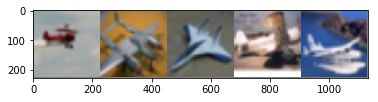

Top Incorrect Prediction


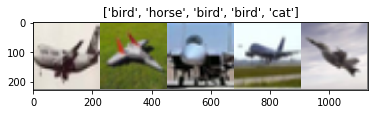

Class: car
Top Correct Prediction


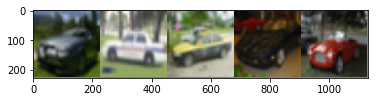

Top Incorrect Prediction


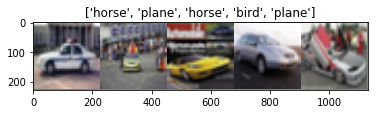

Class: bird
Top Correct Prediction


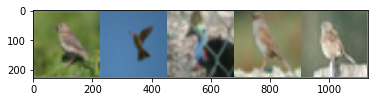

Top Incorrect Prediction


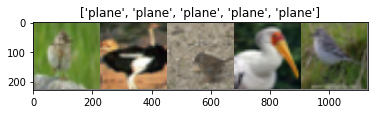

Class: cat
Top Correct Prediction


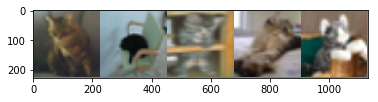

Top Incorrect Prediction


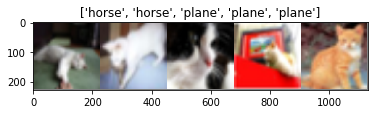

Class: deer
Top Correct Prediction


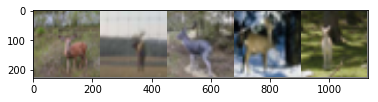

Top Incorrect Prediction


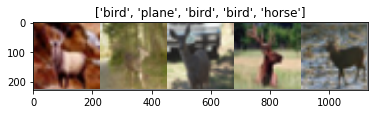

Class: dog
Top Correct Prediction


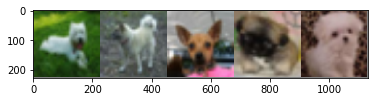

Top Incorrect Prediction


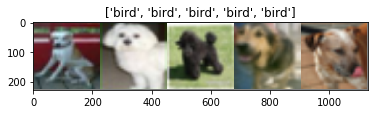

Class: frog
Top Correct Prediction


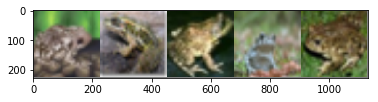

Top Incorrect Prediction


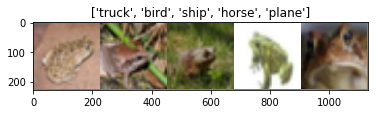

Class: horse
Top Correct Prediction


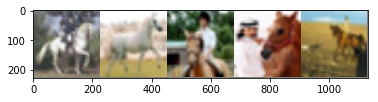

Top Incorrect Prediction


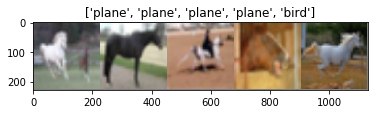

Class: ship
Top Correct Prediction


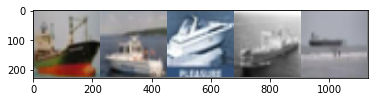

Top Incorrect Prediction


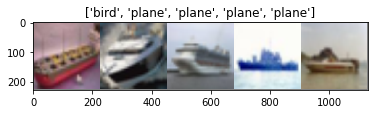

Class: truck
Top Correct Prediction


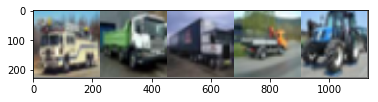

Top Incorrect Prediction


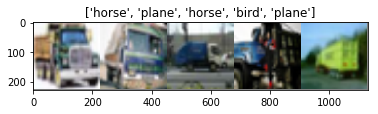

In [21]:
top_correct_incorrect(model_conv,validation_labels,classes,dataloaders["val"])